# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
import torchvision
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
from tqdm import tqdm
import random
import numpy as np
import cv2
from skimage.util import view_as_windows

# Loading CIFAR10 dataset

In [121]:
def separate():
    print('-'*120)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data_cifar', train=True,
                                        download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='./data_cifar', train=False,
                                       download=True, transform=transform_test)

batch_size = 128

c, w, h = 3, 32, 32

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
classes_org = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
# choose a picture at random
im_minibatch, label_minibatch = next(iter(testloader))
im, label = im_minibatch[0].cpu(), label_minibatch[0].cpu()

# store image size dimensions
image_size = tuple(im.shape)

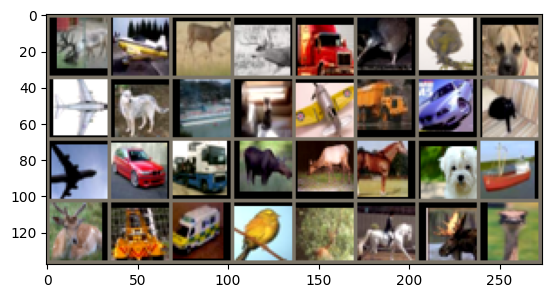

deer  plane deer  deer  truck bird  bird  dog   plane dog   ship  cat   plane truck car   cat   plane car   truck deer  deer  horse dog   ship  deer  truck car   bird  deer  horse deer  bird 


In [6]:
# function to show an image
def show(X):    
    if isinstance(X, np.ndarray):
        X = torch.Tensor(X)
                
    X = inverse_transform(X)

    # Clip to valid range for floats
    rgb_data = np.clip(X.numpy(), 0, 1)

    # Clip to valid range for integers
    rgb_data = np.clip(rgb_data, 0, 255)
    
    plt.imshow(np.transpose(rgb_data, (1, 2, 0)))
    plt.show()
    
inverse_transform = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), 
                                        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),])


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
show(torchvision.utils.make_grid(images[0:32]))
# print labels
print(' '.join(f'{classes_org[labels[j]]:5s}' for j in range(batch_size//4)))

# Loading MobileNetV2 model

In [7]:
def load_model(classes):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)

    # Replace the final fully-connected layer
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = torch.nn.Linear(num_ftrs, len(classes))
    
    return model

In [8]:
%%capture
model_org = load_model(classes_org)
model_org.to(device)

# Training (do not train as it was done and weights are already available)

In [9]:
def train_model(model, trainloader, testloader, weights_dir, num_epochs=100):
    start=time.time()
    
    error = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(0,num_epochs):

        model.train()  # Put the network in train mode
        for i, (x_batch, y_batch) in enumerate(trainloader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

            optimizer.zero_grad()  # Set all currenly stored gradients to zero 

            y_pred = model(x_batch)

            loss = error(y_pred, y_batch)

            loss.backward()

            optimizer.step()

            # Compute relevant metrics

            y_pred_max = torch.argmax(y_pred, dim=1)  # Get the labels with highest output probability

            correct = torch.sum(torch.eq(y_pred_max, y_batch)).item()  # Count how many are equal to the true labels

            elapsed = time.time() - start  # Keep track of how much time has elapsed

            # Show progress every 20 batches 
            if not i % 20:
                print(f'epoch: {epoch}, time: {elapsed:.3f}s, loss: {loss.item():.3f}, train accuracy: {correct / batch_size:.3f}')

        correct_total = 0

        model.eval()  # Put the network in eval mode
        for i, (x_batch, y_batch) in enumerate(testloader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

            y_pred = model(x_batch)
            y_pred_max = torch.argmax(y_pred, dim=1)

            correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

        print(f'Accuracy on the test set: {correct_total / len(testset):.3f}')

        # Save weights every 10 epochs
        if epoch%10==0:
            torch.save(model.state_dict(), f"./{weights_dir}/epoch-{epoch}_accuracy-{correct_total/len(testset):.3f}.pth")
    

In [10]:
if os.path.exists(os.path.join('weights')):
    shutil.rmtree(os.path.join('weights'))
!mkdir weights2

In [ ]:
train_model(model_org, trainloader, testloader, 'weights')

# Load latest weights

In [9]:
def load_weights(classes, model, weights_dir):
    files = os.listdir(weights_dir)
    weight_paths = [os.path.join(weights_dir, basename) for basename in files]
    final_weight_file = os.path.basename(max(weight_paths, key=os.path.getctime))

    model = load_model(classes)

    model.load_state_dict(torch.load(os.path.join(weights_dir, final_weight_file), map_location=device))
    print('Loaded weights: ' + final_weight_file)
    
    return model

In [10]:
model_org = load_weights(classes_org, model_org, 'weights')

Loaded weights: epoch-90_accuracy-0.842.pth


Using cache found in C:\Users\raulv/.cache\torch\hub\pytorch_vision_v0.10.0


In [11]:
%%capture
model_org.to(device)
# sets the module in eval node
model_org.eval()

# Evaluation

In [118]:
def show_examples(classes, testloader, model):
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    # print images
    show(torchvision.utils.make_grid(images[:16]))
    print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(16)))

    images = images.to(device)
    outputs = model(images)

    _, predicted = torch.max(outputs, 1)

    separate()
    print('Predicted:   ', ' '.join(f'{classes[predicted[j]]:5s}'
                                  for j in range(16)))

In [127]:
def show_accuracies(classes, testloader, model):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

    correct_total = 0
    for i, (x_batch, y_batch) in enumerate(testloader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

        y_pred = model(x_batch)
        y_pred_max = torch.argmax(y_pred, dim=1)

        correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()
    separate()
    print(f'Accuracy on the test set: {correct_total / len(testset):.3f}')

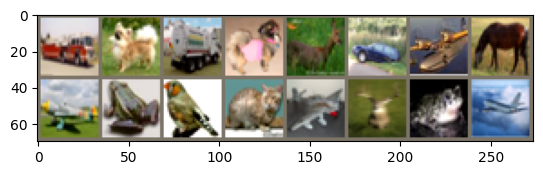

GroundTruth:  truck dog   truck dog   deer  car   plane horse plane frog  bird  cat   plane deer  frog  plane
------------------------------------------------------------------------------------------------------------------------
Predicted:    truck dog   truck dog   deer  car   plane horse plane frog  bird  cat   car   deer  frog  plane


In [125]:
show_examples(classes_org, testloader, model_org)

In [128]:
show_accuracies(classes_org, testloader, model_org)

Accuracy for class: plane is 87.1 %
Accuracy for class: car   is 91.9 %
Accuracy for class: bird  is 77.5 %
Accuracy for class: cat   is 65.6 %
Accuracy for class: deer  is 83.2 %
Accuracy for class: dog   is 79.6 %
Accuracy for class: frog  is 90.5 %
Accuracy for class: horse is 84.2 %
Accuracy for class: ship  is 90.4 %
Accuracy for class: truck is 91.7 %
------------------------------------------------------------------------------------------------------------------------
Accuracy on the test set: 0.842


# Adversarial attack

In [73]:
class GeneticAlgorithm:
    def __init__(self, model, im_size, start_population=None, pop_size=100, best_pop_percent=0.8, random_pop_percent=0.05, mutation_rate=0.05,
                 print_results=False, early_stopping=True, num_gen_no_change=50):
        self.model = model
        self.im_size = im_size
        self.start_population = start_population
        self.pop_size = pop_size
        self.best_pop_percent = best_pop_percent
        self.random_pop_percent = random_pop_percent
        self.mutation_rate = mutation_rate
        self.print_results = print_results
        self.early_stopping = early_stopping
        self.num_gen_no_change = num_gen_no_change


    def optimize(self, fitness_fn, adv_target, num_of_gen, print_interval):
        self.adv_target = adv_target
        
        if self.start_population is not None:
            self.population = self.load_population()
        else:
            self.population = self.initial_population()
    
        results = np.zeros(len(self.population))
        prev_results = np.zeros(len(self.population))
        no_change_count = 0

        for gen in range(num_of_gen):
            self.population, results = self.evolve(fitness_fn)
            if np.isclose(prev_results[:10], results[:10]).all():
                no_change_count += 1
            else:
                no_change_count = 0
                prev_results = results
            
            if self.print_results:
                if gen == 0:
                    print("Generation #: best result")
                elif gen == num_of_gen - 1:
                    print("Generation ", gen, ": ", results[0])
                elif gen % print_interval == 0:
                    print("Generation ", gen, ": ", results[0])
                    
            if np.isclose(results[:10], 1).any() or (self.early_stopping and no_change_count >= self.num_gen_no_change):
                if self.print_results:
                    print("Early exit on iteration ", gen, " with best result ", results[0])
                break

        return self.population[0]
    
    def load_population(self):
        """
        Loading initial population
        """
        return np.array([self.start_population.numpy() for _ in range(self.pop_size)])
        
    def initial_population(self):
        """
        Creating initial population of individual solutions
        """
        return np.random.rand(self.pop_size, *self.im_size)


    def evolve(self, fitness_fn):
        """
        Evolving the population to the next generation
        """
        scores = self.evaluate_population(self.population, fitness_fn)

        elite_size = int(self.best_pop_percent * self.pop_size)
        elite_indices = np.argsort(scores)[-elite_size:]
        elite = [self.population[i] for i in elite_indices]

        random_size = int(self.random_pop_percent * self.pop_size)
        random_indices = np.random.randint(0, self.pop_size, random_size)
        random_population = [self.population[i] for i in random_indices]

        children = []
        while len(children) < self.pop_size - elite_size - random_size:
            parent1_idx, parent2_idx = np.random.randint(0, elite_size - random_size - 1, 2)
            parent1 = self.population[parent1_idx]
            parent2 = self.population[parent2_idx]
            
            child = self.crossover(parent1, parent2)

            if np.random.random() < self.mutation_rate:
                child = self.mutate(child)
            children.append(child)

        next_population = elite + random_population + children
        return next_population, scores

    def crossover(self, parent1, parent2):
        """
        Crossover operation
        """
        condition = np.random.rand(*parent1.shape) < 0.5
        return np.where(condition, parent1, parent2)     

    def mutate(self, child, mutation_rate=0.1, mu=0, sigma=10):
        """
        Mutation operation
        """
        mask = np.random.binomial(1, mutation_rate, size=child.shape).astype(bool)
        noise = np.random.normal(mu, sigma, size=child.shape)
        child[mask] += noise[mask]
        return child
    
    def evaluate_population(self, population, fitness_function):
        """
        Apply fitness function to each population member
        """
        population = np.array(population)
        return fitness_function(population, self.adv_target, self.model)


In [60]:
def fitness_class_probability(X, adv_target, model):
    """ Maximize probability of adversarial target class"""
    y = model(torch.Tensor(X).to(device)).to('cpu').detach().numpy()
    y_target = y[:, adv_target]
    return y_target

In [18]:
def fitness_copy(X, adv_target, model):
    """ Attempts to make a copy of testset[10][0] """
    fitness = []
    batch_images = np.repeat(testset[10][0].numpy()[np.newaxis,:,:,:], X.shape[0], axis=0)

    for i in range(X.shape[0]):
        fitness.append(np.sum(np.abs(batch_images[i] - X[i])))
    fitness = np.sum(batch_images) - np.array(fitness)
    return fitness

In [79]:
def fitness_similarity(X, adv_target, model):
    """ Maximize adv_target probability while MSE from testset[10][0] """
    batch_images = np.repeat(testset[10][0].numpy()[np.newaxis,:,:,:], X.shape[0], axis=0)
    y = model(torch.Tensor(X).to(device)).to('cpu').detach().numpy()
    y_target = y[:, adv_target]
    mse = np.sqrt(np.power(X - batch_images, 2).mean(axis=1).mean(axis=1).mean(axis=1))
    return y_target-mse

In [132]:
def show_probabilities(X, model, classes):
    if isinstance(X, np.ndarray):
        X = torch.Tensor(X)
    prob = F.softmax(model(X.unsqueeze(0).to(device)), dim=1)

    print('Confidence scores:\n' + '\n'.join(['{}: {}'.format(classes[i], p.item()) for i, p in enumerate(prob.squeeze())])) 
    separate()
    print('Label with highest confidence score: {}'.format(classes[torch.argmax(prob).item()]))

## Attack with a single sample

In [133]:
def attack(classes, attack_class, model, num_of_gen=1000, fitness_function=fitness_class_probability, start_population=None):
    adv_target = classes.index(attack_class)
    ga = GeneticAlgorithm(model=model, im_size=image_size, start_population=start_population, print_results=False, early_stopping=False)
    result = ga.optimize(fitness_function, adv_target, num_of_gen=num_of_gen, print_interval=500)
    print("Attack finished")
    return result

### Attack by using "noisy" generated image

In [134]:
generated_sample = attack(classes_org, 'frog', model_org)

Attack finished


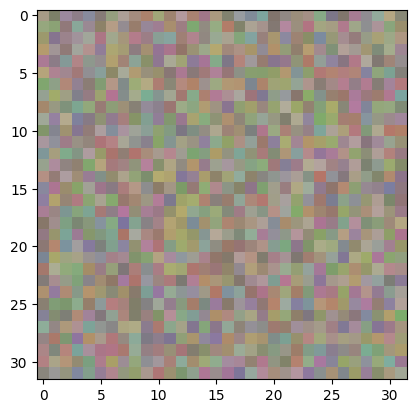

Confidence scores:
plane: 1.845879675819438e-17
car: 4.54291033485471e-17
bird: 3.0453594507262594e-11
cat: 5.881383713379762e-10
deer: 1.3305630468946061e-12
dog: 2.9904254257324264e-14
frog: 1.0
horse: 8.477279907270817e-16
ship: 2.3564228536334815e-20
truck: 1.1785661426721658e-16
------------------------------------------------------------------------------------------------------------------------
Label with highest confidence score: frog
------------------------------------------------------------------------------------------------------------------------
~~~Attack was successful!~~~


In [136]:
show(generated_sample)
show_probabilities(generated_sample, model_org, classes_org)
separate()
print('~~~Attack was successful!~~~')

### Attack by using a real image

In [137]:
generated_sample = attack(classes_org, 'frog', model_org, fitness_function=fitness_similarity, start_population=testset[0][0])

Attack finished


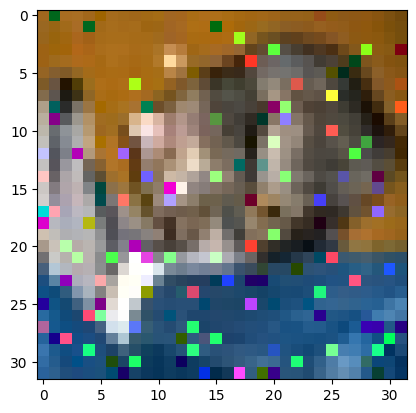

Confidence scores:
plane: 7.433733533249165e-13
car: 2.4276826209035374e-13
bird: 7.945337721082524e-09
cat: 9.282664414911324e-09
deer: 2.533672707402679e-12
dog: 2.982682850705132e-11
frog: 1.0
horse: 7.848174150490439e-13
ship: 2.2600839155465886e-17
truck: 1.1161627584644826e-13
------------------------------------------------------------------------------------------------------------------------
Label with highest confidence score: frog
------------------------------------------------------------------------------------------------------------------------
~~~Attack was successful!~~~


In [138]:
show(generated_sample)
show_probabilities(generated_sample, model_org, classes_org)
separate()
print('~~~Attack was successful!~~~')

# Adversarial defence from "noisy" generated images

## Generating a dataset of adversarial examples (no need to run, can be loaded from noise_data.pt)

In [22]:
generate_adversarial_dataset = False

if generate_adversarial_dataset:
    if os.path.exists(os.path.join('adversarial_dataset')):
        shutil.rmtree(os.path.join('adversarial_dataset'))
    !mkdir adversarial_dataset

In [30]:
# set number of images to generate per class
numImgsPerClass = 600

In [ ]:
# This took 20 hours to generate
noise_data = []

for aClass in classes_org:
    print('Generating adversarial examples for class: ' + aClass)
    
    for i in tqdm(range(0,numImgsPerClass)):
        generated_img = attack(classes_org, aClass, model_org)
        noise_data.append((torch.Tensor(generated_img), torch.as_tensor(10)))

In [ ]:
if generate_adversarial_dataset:
    # Save the noise data to a file
    torch.save(noise_data, 'adversarial_dataset/noise_data.pt')

## Method 1: Training on generated adversarial images

## Creating new dataset with adversarial examples

In [139]:
noise_data = torch.load('adversarial_dataset/noise_data.pt')

In [140]:
random.shuffle(noise_data)
noise_data_train = noise_data[:5000]
noise_data_test = noise_data[5000:]

In [141]:
cifar_data_train = []
cifar_data_test = []

for images, labels in trainloader:
    for image, label in zip(images, labels):
        cifar_data_train.append((image, label))
        
for images, labels in testloader:
    for image, label in zip(images, labels):
        cifar_data_test.append((image, label))

In [142]:
combined_data_train = noise_data_train + cifar_data_train
combined_data_test = noise_data_test + cifar_data_test

In [143]:
class CombinedDataset(Dataset):
    def __init__(self, combined_data):
        self.combined_data = combined_data

    def __len__(self):
        return len(self.combined_data)

    def __getitem__(self, idx):
        return self.combined_data[idx]

batch_size = 128
    
combined_dataset_train = CombinedDataset(combined_data_train)
combined_dataset_test = CombinedDataset(combined_data_test)
combined_dataloader_train = DataLoader(combined_dataset_train, batch_size=batch_size, shuffle=True)
combined_dataloader_test = DataLoader(combined_dataset_test, batch_size=batch_size, shuffle=True)

## Create new model for training

In [32]:
# MobileNetV2 needs to be trained now on 11 classes

In [144]:
classes_adv = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'generated')

In [145]:
%%capture
model_adv = load_model(classes_adv)
model_adv.to(device)

## Adversarial training (do not train as it was done and weights are already available)

In [34]:
if os.path.exists(os.path.join('adversarial_weights')):
    shutil.rmtree(os.path.join('adversarial_weights'))
!mkdir adversarial_weights

In [ ]:
train_model(model_adv, combined_dataloader_train, combined_dataloader_test, 'adversarial_weights')

## Evaluation of adversarially trained model

In [146]:
model_adv = load_weights(classes_adv, model_adv, 'adversarial_weights')

Loaded weights: epoch-90_accuracy-0.782.pth


Using cache found in C:\Users\raulv/.cache\torch\hub\pytorch_vision_v0.10.0


In [147]:
%%capture
model_adv.to(device)
# sets the module in eval node
model_adv.eval()

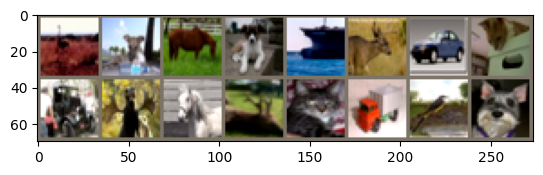

GroundTruth:  bird  dog   horse dog   ship  deer  car   cat   truck deer  horse deer  cat   truck bird  dog  
------------------------------------------------------------------------------------------------------------------------
Predicted:    cat   plane horse horse plane deer  car   cat   truck dog   horse deer  cat   dog   horse cat  


In [148]:
show_examples(classes_adv, combined_dataloader_test, model_adv)

In [149]:
show_accuracies(classes_adv, combined_dataloader_test, model_adv)
print("\n~~~Overall accuracy is decreased. However, all generated images based on original model are now detected!~~~")

Accuracy for class: plane is 74.8 %
Accuracy for class: car   is 81.5 %
Accuracy for class: bird  is 60.3 %
Accuracy for class: cat   is 43.6 %
Accuracy for class: deer  is 68.1 %
Accuracy for class: dog   is 56.8 %
Accuracy for class: frog  is 78.5 %
Accuracy for class: horse is 63.7 %
Accuracy for class: ship  is 78.3 %
Accuracy for class: truck is 76.3 %
Accuracy for class: generated is 100.0 %
------------------------------------------------------------------------------------------------------------------------
Accuracy on the test set: 0.782

~~~Overall accuracy is decreased. However, all generated images based on original model are now detected!~~~


### Attacking using generated images based on original model **(model_org)**

In [150]:
# Generate based on original model
generated_frog = attack(classes_adv, 'frog', model_org)

Attack finished


In [151]:
# Pass images generated on model_org to model_adv for detection
show_probabilities(generated_frog, model_adv, classes_adv)

Confidence scores:
plane: 1.1612626285436742e-18
car: 1.4908738884198365e-19
bird: 3.2174004698153376e-18
cat: 5.370982823480053e-23
deer: 5.2383331940240145e-20
dog: 6.495113380230818e-26
frog: 4.0196851159795843e-25
horse: 1.7187578143438964e-25
ship: 3.1517934501676945e-16
truck: 3.123623016694898e-20
generated: 1.0
------------------------------------------------------------------------------------------------------------------------
Label with highest confidence score: generated


### Attacking using generated images based on new adversarially trained model **(model_adv)**

In [152]:
# Generate based on new model
generated_frog = attack(classes_adv, 'frog', model_adv)

Attack finished


In [154]:
show_probabilities(generated_frog, model_adv, classes_adv)
separate()
print("~~~Model has been fooled again after it was trained to detect generated images. Newly generated images on model_adv learned to bypass adversarial training!~~~")

Confidence scores:
plane: 2.366152210159467e-19
car: 8.392510517712517e-20
bird: 1.2569942570871792e-19
cat: 2.3945966584805077e-15
deer: 1.1103615939213714e-17
dog: 4.358958090664066e-22
frog: 1.0
horse: 8.878419651261699e-24
ship: 1.8509970493585126e-19
truck: 3.8723467759934927e-19
generated: 0.0
------------------------------------------------------------------------------------------------------------------------
Label with highest confidence score: frog
------------------------------------------------------------------------------------------------------------------------
~~~Model has been fooled again after it was trained to detect generated images. Newly generated images on model_adv learned to bypass adversarial training!~~~


### So, adversarial training does not work on images generated using adversarial model. It works only with images generated using original model :(

## Method 2: Data pre-processing

## Finding minimum std of pixel regions in image

In [155]:
def find_min_std(img):
    if isinstance(img, torch.Tensor):
        img = img.numpy()

    # Load the image and convert it to grayscale
    image = np.transpose(img, (1, 2, 0))
    image_8u = cv2.convertScaleAbs(image, alpha=255)
    gray_image = cv2.cvtColor(image_8u, cv2.COLOR_BGR2GRAY)

    # Define the patch size and overlap
    patch_size = (3, 3)
    overlap = (1, 1)

    # Compute the grid of patches
    patches = view_as_windows(gray_image, patch_size, overlap)

    # Compute the standard deviation of the pixel intensities in each patch
    patch_stds = np.std(patches, axis=(-1, -2))

    return min(np.array(patch_stds).flatten().tolist())

In [156]:
# NOT USED ANYMORE

def frequency_domain_detection(image: torch.Tensor) -> float:
    # Convert the image to numpy array
    image = image.numpy().transpose(1,2,0)
    image_8u = cv2.convertScaleAbs(image, alpha=255)

    # Convert image to grayscale
    gray_image = cv2.cvtColor(image_8u, cv2.COLOR_RGB2GRAY)
    # perform FFT on grayscale image
    fft_image = np.fft.fft2(gray_image)
    # shift the FFT to center
    fft_image = np.fft.fftshift(fft_image)
    # calculate the mean of the magnitude
    std = np.std(np.abs(fft_image))
    return std

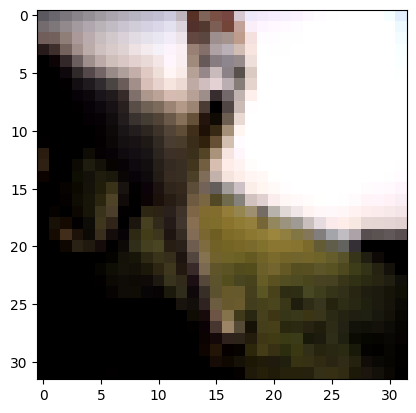

Patch of pixels with smallest std = 0.0


In [157]:
show(cifar_data_test[0][0])
print('Patch of pixels with smallest std =', str(find_min_std(cifar_data_test[0][0])))

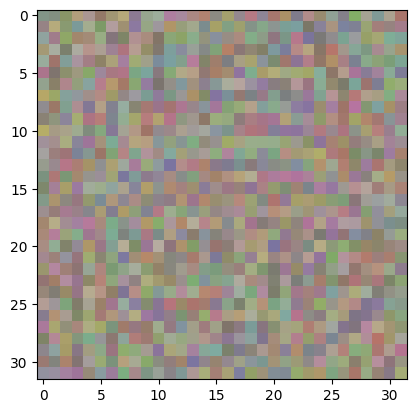

Patch of pixels with smallest std = 16.165807537309522


In [158]:
show(noise_data[0][0])
print('Patch of pixels with smallest std =', str(find_min_std(noise_data[0][0])))

In [159]:
stds = []
for data in cifar_data_train+cifar_data_test:
    stds.append(find_min_std(data[0]))

print('Minimum min std of all samples in CIFAR10 dataset: ' + str(min(stds)))
print('Maximum min std of all samples in CIFAR10 dataset: ' + str(max(stds)))
separate()

stds = []
for data in noise_data:
    stds.append(find_min_std(data[0]))

print('Minimum min std of all samples in noise_data: ' + str(min(stds)))
print('Maximum min std of all samples in noise_data: ' + str(max(stds)))

Minimum min std of all samples in CIFAR10 dataset: 0.0
Maximum min std of all samples in CIFAR10 dataset: 14.775689075448257
------------------------------------------------------------------------------------------------------------------------
Minimum min std of all samples in noise_data: 3.8999841721742765
Maximum min std of all samples in noise_data: 24.632609120813115


In [48]:
print(str(60000 - len([1 for data in cifar_data_train+cifar_data_test if find_min_std(data[0])<3])) + ' samples from CIFAR10 are going to be incorrectly labeled as generated by data pre-processing')

440 samples from CIFAR10 are going to be incorrectly labeled as generated by data pre-processing


In [160]:
class CustomMobileNetV2(torch.nn.Module):
    def __init__(self):
        super(CustomMobileNetV2, self).__init__()
        self.model = load_model(classes_org)
        self.model = load_weights(classes_org, self.model, 'weights')
        
    def forward(self, x):
        # Pass the image through the model and return the predicted label
        with torch.no_grad():
            logits = self.model(x)
            
            # create a tensor of -1000 with shape (batch_size,1)
            generated_label = torch.full((x.shape[0],1),-1000,dtype=x.dtype, device=device)

            # concatenate the logits and generated_label along the second dimension
            logits = torch.cat((logits, generated_label), dim=1)

            for i in range(x.shape[0]):
                min_std = find_min_std(x[i].squeeze(0).cpu())
                if min_std > 3.0:
                    logits[i] = torch.tensor([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 1], dtype=x.dtype, device=device)

            return logits

In [161]:
%%capture
# Wrap the model in a CustomModel object
model_preprocessing = CustomMobileNetV2()
model_preprocessing.to(device)
model_preprocessing.eval()

In [162]:
# Generate based on original model
generated_frog_org = attack(classes_adv, 'frog', model_org)

Attack finished


In [163]:
# Generate based on adversarially trained model
generated_frog_adv = attack(classes_adv, 'frog', model_adv)

Attack finished


In [167]:
print('Results for a real image:')
show_probabilities(images[0], model_preprocessing, classes_adv)
separate()
print('\nResults for generated image on model_org:')
show_probabilities(generated_frog_org, model_preprocessing, classes_adv)
separate()
print('\nResults for generated image on model_adv:')
show_probabilities(generated_frog_adv, model_preprocessing, classes_adv)
separate()
print('\n~~~Data pre-processing manages to find generated adversarial images based on both model_org and model_adv!~~~')

Results for a real image:
Confidence scores:
plane: 0.0008669347153045237
car: 5.36392763024196e-05
bird: 0.0028903319034725428
cat: 0.20293910801410675
deer: 0.027264023199677467
dog: 0.7619994282722473
frog: 0.0003545328218024224
horse: 0.0035703773610293865
ship: 2.9485192499123514e-05
truck: 3.213169111404568e-05
generated: 0.0
------------------------------------------------------------------------------------------------------------------------
Label with highest confidence score: dog
------------------------------------------------------------------------------------------------------------------------

Results for generated image on model_org:
Confidence scores:
plane: 0.0
car: 0.0
bird: 0.0
cat: 0.0
deer: 0.0
dog: 0.0
frog: 0.0
horse: 0.0
ship: 0.0
truck: 0.0
generated: 1.0
------------------------------------------------------------------------------------------------------------------------
Label with highest confidence score: generated
--------------------------------------

In [168]:
show_accuracies(classes_adv, combined_dataloader_test, model_preprocessing)

Accuracy for class: plane is 86.8 %
Accuracy for class: car   is 91.9 %
Accuracy for class: bird  is 75.0 %
Accuracy for class: cat   is 65.2 %
Accuracy for class: deer  is 76.6 %
Accuracy for class: dog   is 79.1 %
Accuracy for class: frog  is 84.4 %
Accuracy for class: horse is 84.2 %
Accuracy for class: ship  is 90.3 %
Accuracy for class: truck is 91.5 %
Accuracy for class: generated is 100.0 %
------------------------------------------------------------------------------------------------------------------------
Accuracy on the test set: 0.925


## Will genetic algorithm bypass model with data pre-processing when it is attacked directly?

In [170]:
# Generate based on data pre-processing model
generated_frog = attack(classes_adv, 'frog', model_preprocessing)

Attack finished


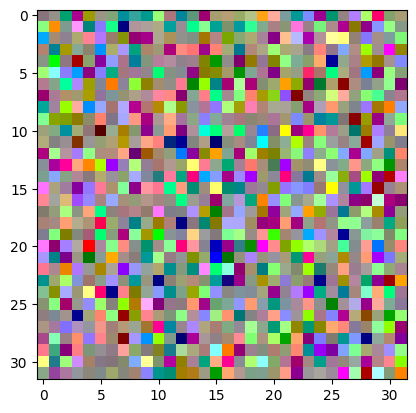

Confidence scores:
plane: 0.0
car: 0.0
bird: 0.0
cat: 0.0
deer: 0.0
dog: 0.0
frog: 0.0
horse: 0.0
ship: 0.0
truck: 0.0
generated: 1.0
------------------------------------------------------------------------------------------------------------------------
Label with highest confidence score: generated


In [171]:
show(generated_frog)
show_probabilities(generated_frog, model_preprocessing, classes_adv)

### Genetic algorithm takes longer to find a solution. In most of the cases, it is unable to arrive to an optimal solution

# Adversarial defence from real looking generated images